## Import Libraries

In [1]:
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
wdi_df = pd.read_csv("data/WDIData.csv")
wdi_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.392349,17.892005,18.359993,18.795151,19.295176,19.788156,20.279599,20.773627,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.720331,7.015917,7.281390,7.513673,7.809566,8.075889,8.366010,8.684137,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.184152,38.543180,38.801719,39.039014,39.323186,39.643848,39.894830,40.213891,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.859257,33.903515,38.851444,40.197332,43.028332,44.389773,46.268621,48.103609,NaN,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.623956,16.516633,24.594474,25.389297,27.041743,29.138285,30.998687,32.772690,NaN,NaN


In [3]:
wdi_df.drop('Unnamed: 67', axis=1, inplace=True)

In [4]:
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

wdi_melt = pd.melt(wdi_df, 
                   id_vars=id_vars, 
                   var_name='Years', 
                   value_name='Score')
wdi_melt.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Years,Score
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,1960,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,1960,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN


In [5]:
series_df = pd.read_csv("data/WDISeries.csv")
series_df.head(2)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,AG.AGR.TRAC.NO,Environment: Agricultural production,"Agricultural machinery, tractors",NaN,Agricultural machinery refers to the number of...,NaN,Annual,NaN,NaN,Sum,...,NaN,NaN,"Food and Agriculture Organization, electronic ...",A tractor provides the power and traction to m...,Agricultural land covers more than one-third o...,NaN,NaN,NaN,CC BY-4.0,NaN
1,AG.CON.FERT.PT.ZS,Environment: Agricultural production,Fertilizer consumption (% of fertilizer produc...,NaN,Fertilizer consumption measures the quantity o...,NaN,Annual,NaN,The world and regional aggregate series do not...,Weighted average,...,NaN,NaN,"Food and Agriculture Organization, electronic ...",Fertilizer consumption measures the quantity o...,"Factors such as the green revolution, has led ...",NaN,NaN,NaN,CC BY-4.0,NaN


In [6]:
eastern_countries = [
"Djibouti",
"Eritrea",
"Ethiopia",
"Kenya",
"Rwanda",
"Sudan",
"Tanzania",
"Uganda"]

eastern_df = wdi_melt[wdi_melt['Country Name'].isin(eastern_countries)]
print(eastern_df.shape)
eastern_df.head()

(744408, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Years,Score
152131,Djibouti,DJI,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
152132,Djibouti,DJI,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,1960,NaN
152133,Djibouti,DJI,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,1960,NaN
152134,Djibouti,DJI,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
152135,Djibouti,DJI,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN


In [7]:
expenditure = [i for i in eastern_df['Indicator Name'] if 'expenditure' in i]
expenditure_df = eastern_df[eastern_df['Indicator Name'].isin(expenditure)]
expenditure_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42840 entries, 152167 to 24730622
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    42840 non-null  object 
 1   Country Code    42840 non-null  object 
 2   Indicator Name  42840 non-null  object 
 3   Indicator Code  42840 non-null  object 
 4   Years           42840 non-null  object 
 5   Score           15662 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.3+ MB


In [8]:
expenditure_df = expenditure_df[(expenditure_df['Years'] >= '2010') & (expenditure_df['Years'] <= '2020')]

In [9]:
merged_df = pd.merge(expenditure_df, 
                     series_df,
                     left_on="Indicator Code",
                     right_on="Series Code",
                     how='left')
merged_df.head(2)

,Country Name,Country Code,Indicator Name_x,Indicator Code,Years,Score,Series Code,Topic,Indicator Name_y,Short definition,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,Djibouti,DJI,Adjusted savings: education expenditure (% of ...,NY.ADJ.AEDU.GN.ZS,2010,7.802883e+00,NY.ADJ.AEDU.GN.ZS,Economic Policy & Debt: National accounts: Adj...,Adjusted savings: education expenditure (% of ...,NaN,...,NaN,NaN,World Bank staff estimates using data from the...,NaN,NaN,NaN,NaN,NaN,CC BY-4.0,NaN
1,Djibouti,DJI,Adjusted savings: education expenditure (curre...,NY.ADJ.AEDU.CD,2010,8.941872e+07,NY.ADJ.AEDU.CD,Economic Policy & Debt: National accounts: Adj...,Adjusted savings: education expenditure (curre...,NaN,...,NaN,NaN,World Bank staff estimates using data from the...,NaN,NaN,NaN,NaN,NaN,CC BY-4.0,NaN


In [10]:
neccessary_columns = ['Country Name', 'Indicator Name_x', 'Topic', 'Years', 'Score']

merged_df = merged_df[neccessary_columns]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country Name      7480 non-null   object 
 1   Indicator Name_x  7480 non-null   object 
 2   Topic             7480 non-null   object 
 3   Years             7480 non-null   object 
 4   Score             5057 non-null   float64
dtypes: float64(1), object(4)
memory usage: 292.3+ KB


In [11]:
indicators = ['Current health expenditure (% of GDP)',
'Domestic general government health expenditure (% of current health expenditure)',
'Domestic general government health expenditure (% of GDP)',
'Domestic general government health expenditure (% of general government expenditure)',
'Domestic private health expenditure (% of current health expenditure)',
'External health expenditure (% of current health expenditure)',
'Out-of-pocket expenditure (% of current health expenditure)']
health_df = merged_df[merged_df['Indicator Name_x'].isin(indicators)]
print(health_df.shape)
health_df.head()

(616, 5)


,Country Name,Indicator Name_x,Topic,Years,Score
6,Djibouti,Current health expenditure (% of GDP),Health: Health systems,2010,3.061504
11,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,60.679157
12,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,1.857695
13,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,6.970487
16,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,2010,29.537765


In [12]:
health_df.head()

,Country Name,Indicator Name_x,Topic,Years,Score
6,Djibouti,Current health expenditure (% of GDP),Health: Health systems,2010,3.061504
11,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,60.679157
12,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,1.857695
13,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,6.970487
16,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,2010,29.537765


In [13]:
health_df['Years'] = pd.to_datetime(health_df['Years'])
health_df.set_index('Years', inplace=True)
health_df.tail()

,Country Name,Indicator Name_x,Topic,Score
Years,,,,
2020-01-01,Uganda,Domestic general government health expenditure...,Health: Health systems,0.672564
2020-01-01,Uganda,Domestic general government health expenditure...,Health: Health systems,3.138830
2020-01-01,Uganda,Domestic private health expenditure (% of curr...,Health: Health systems,41.942467
2020-01-01,Uganda,External health expenditure (% of current heal...,Health: Health systems,41.082459
2020-01-01,Uganda,Out-of-pocket expenditure (% of current health...,Health: Health systems,37.445602


In [14]:
# Renaming columns
health_df.rename(columns={
    'Country Name': 'Country',
    'Indicator Name_x': 'Indicator Name',
    'Score' : 'Percentage'
}, inplace=True)
health_df.head()

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,3.061504
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,60.679157
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.857695
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,6.970487
2010-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,29.537765


In [15]:
def create_dfs(df):
    indicators = [i for i in df['Indicator Name'].unique()]
    dfs = {}
    for i in indicators:
        dfs[i] = df[df['Indicator Name'] == i]
    return dfs

def create_country_dfs(df):
    countries = [country for country in df['Country'].unique()]
    indicator_dfs = create_dfs(df) 
    country_dfs = {}
    
    for c in countries:
        country_dfs[c] = {} 
        for indicator, indicator_df in indicator_dfs.items():
            country_df = indicator_df[indicator_df['Country'] == c]
            country_df['Percentage Diff'] = country_df['Percentage'].diff()
            country_df['Percentage Diff'] = country_df['Percentage Diff'].fillna(0)
            country_dfs[c][indicator] = country_df
            
    return country_dfs

In [16]:
countries = create_country_dfs(health_df)
indicators = create_dfs(health_df)

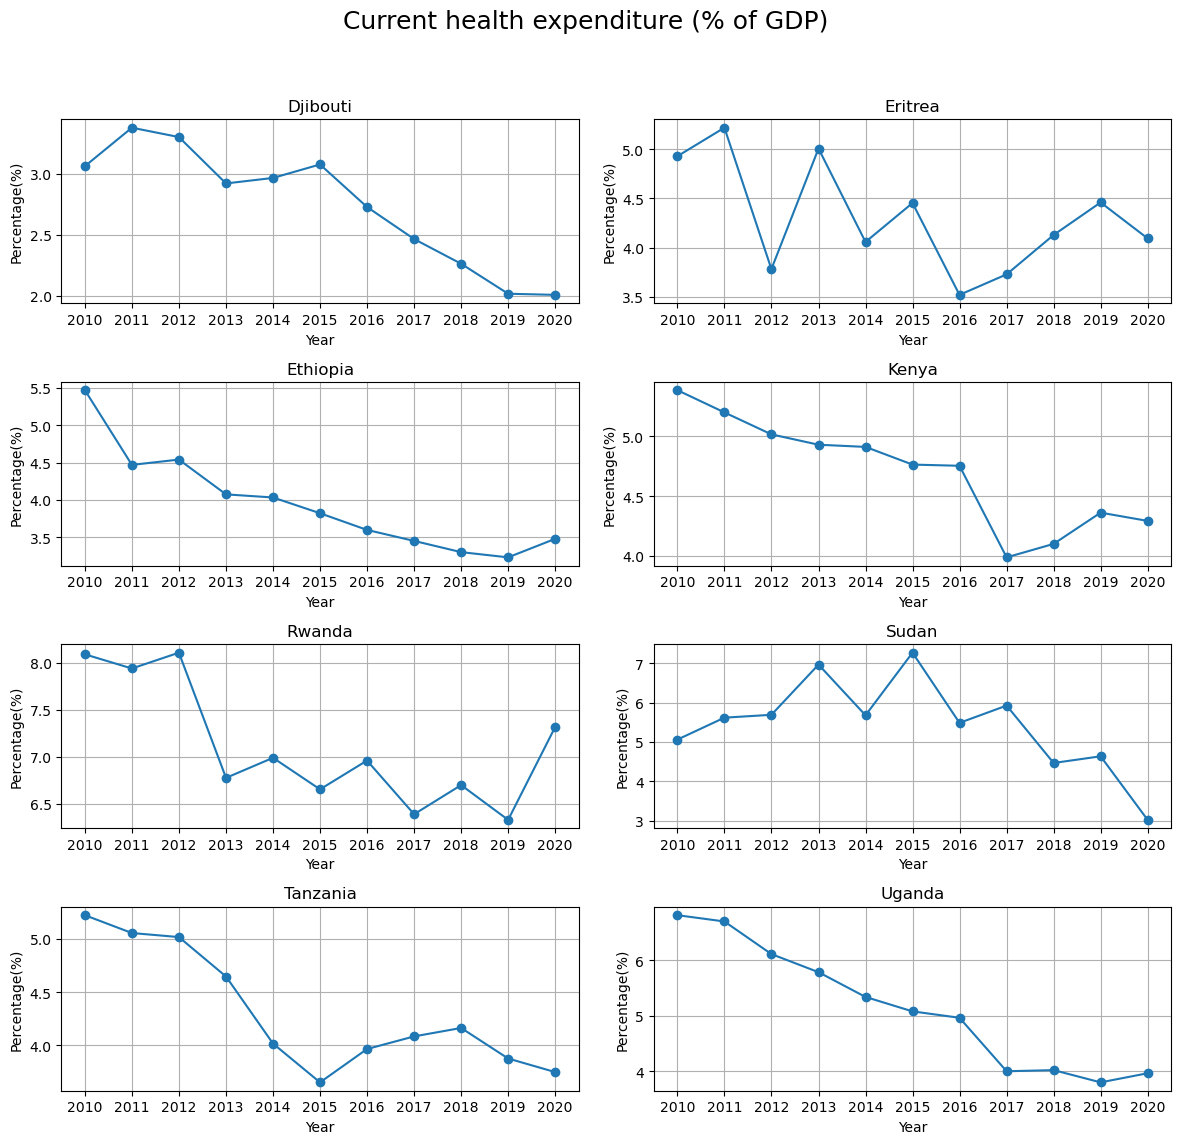

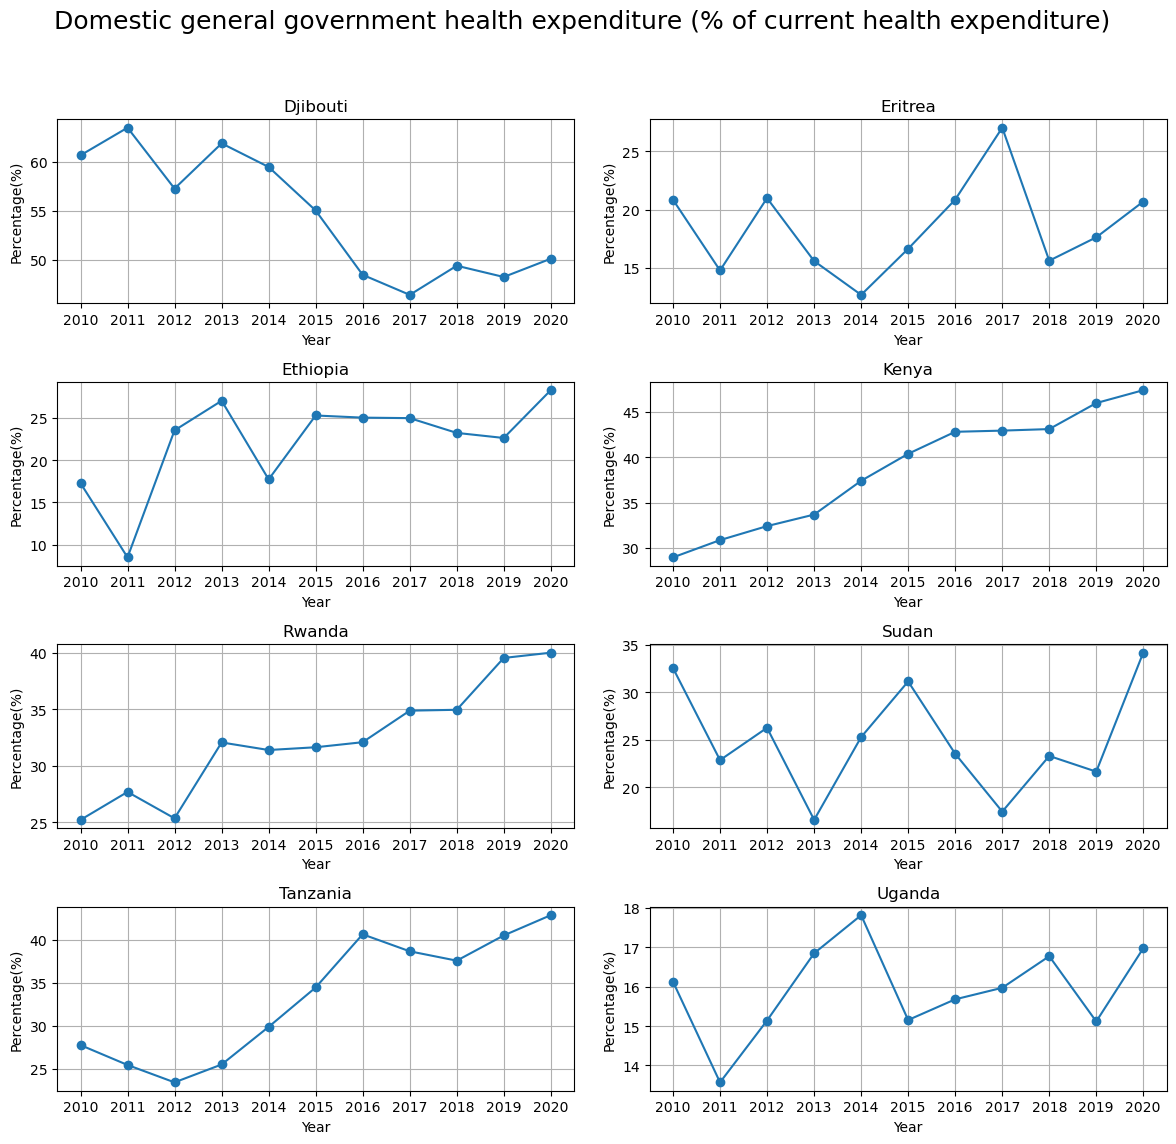

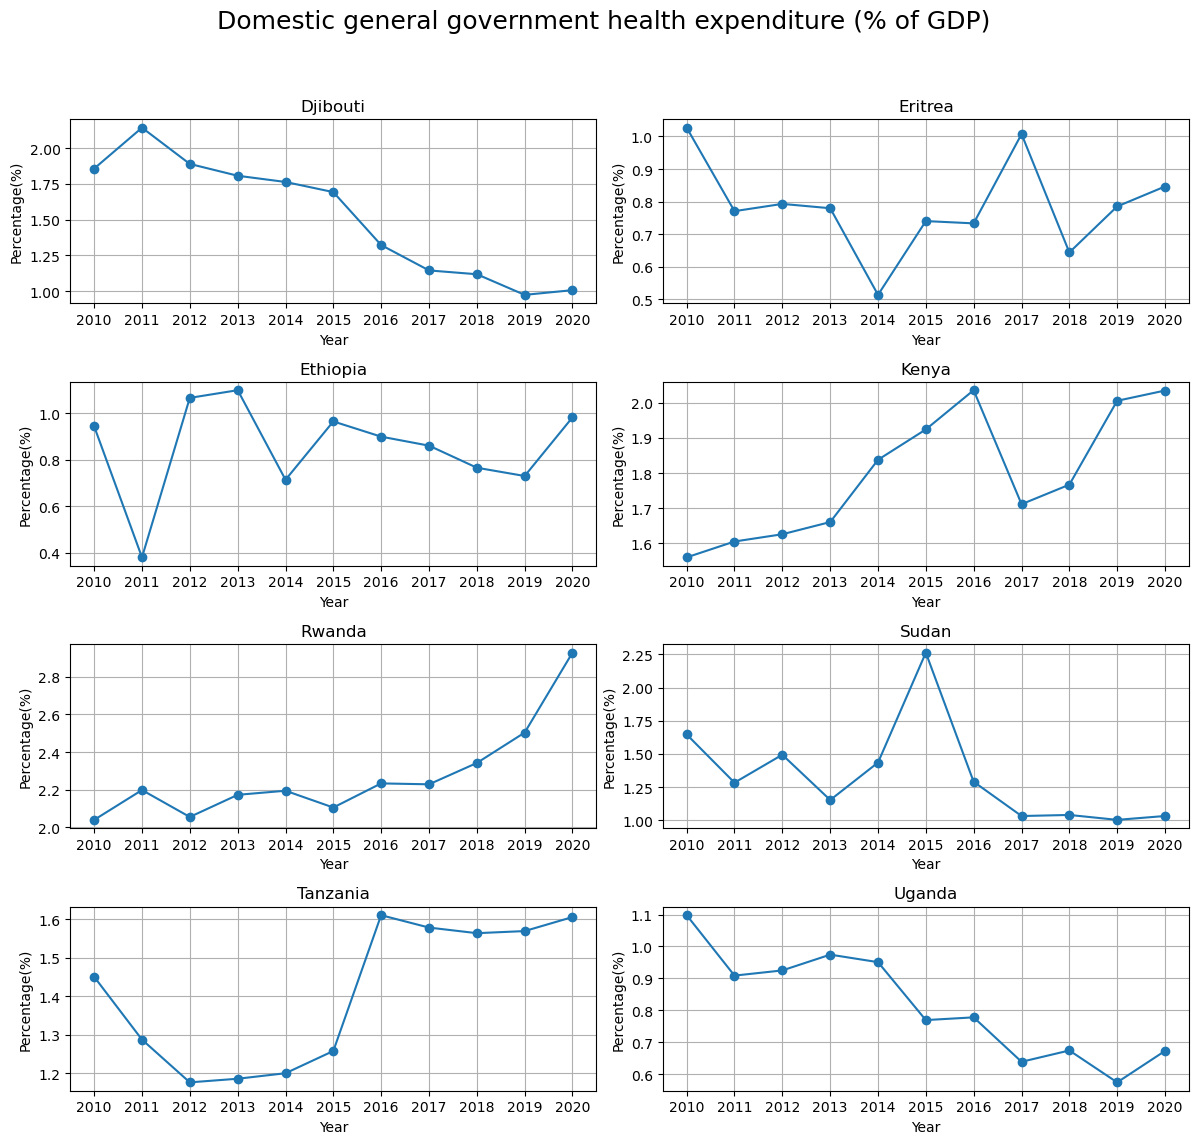

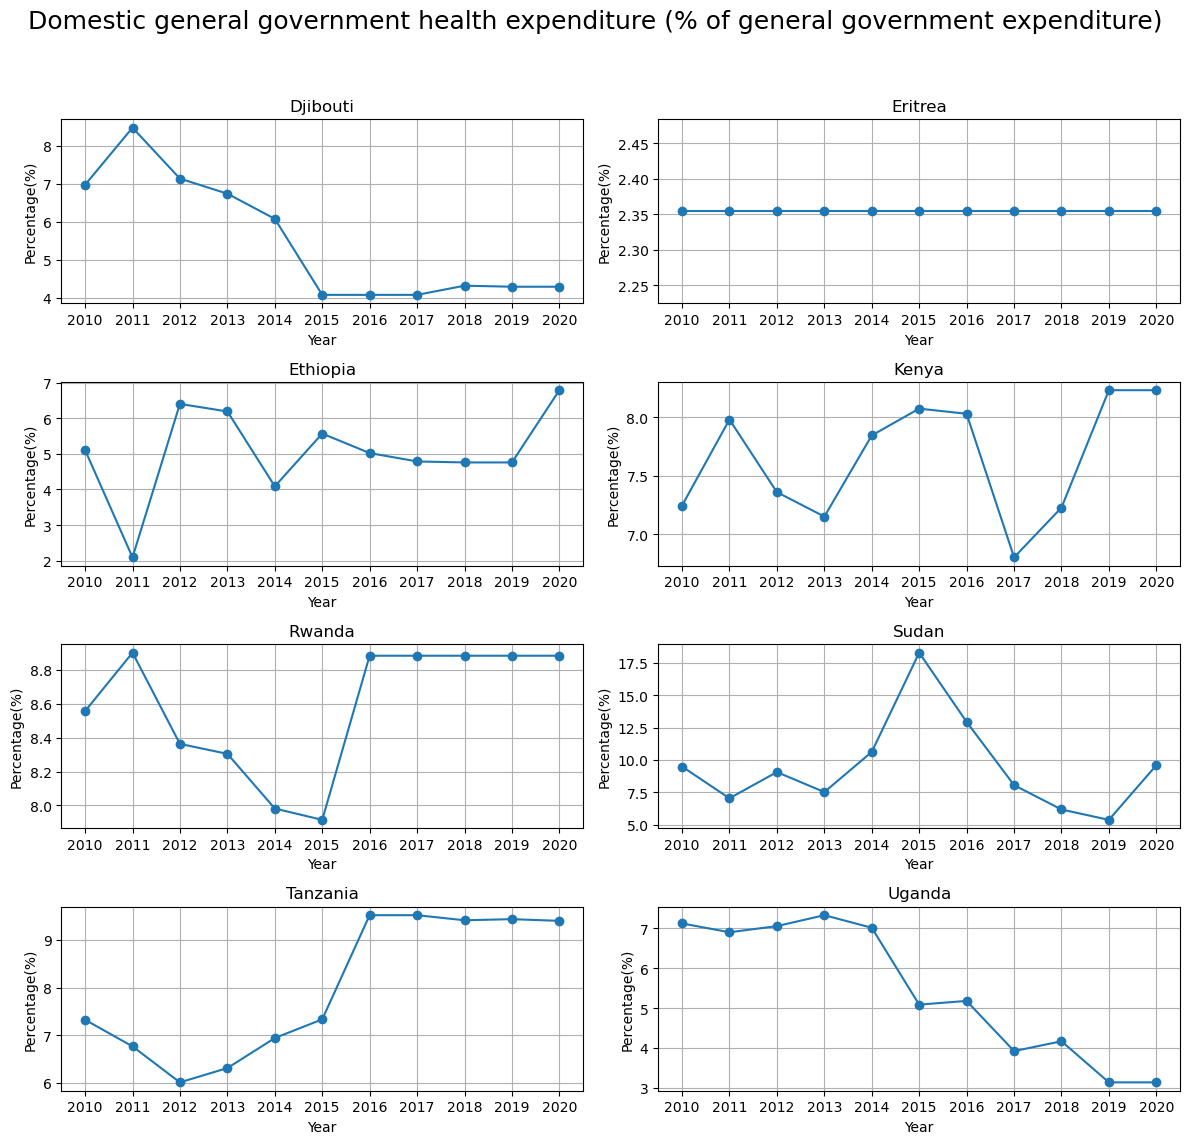

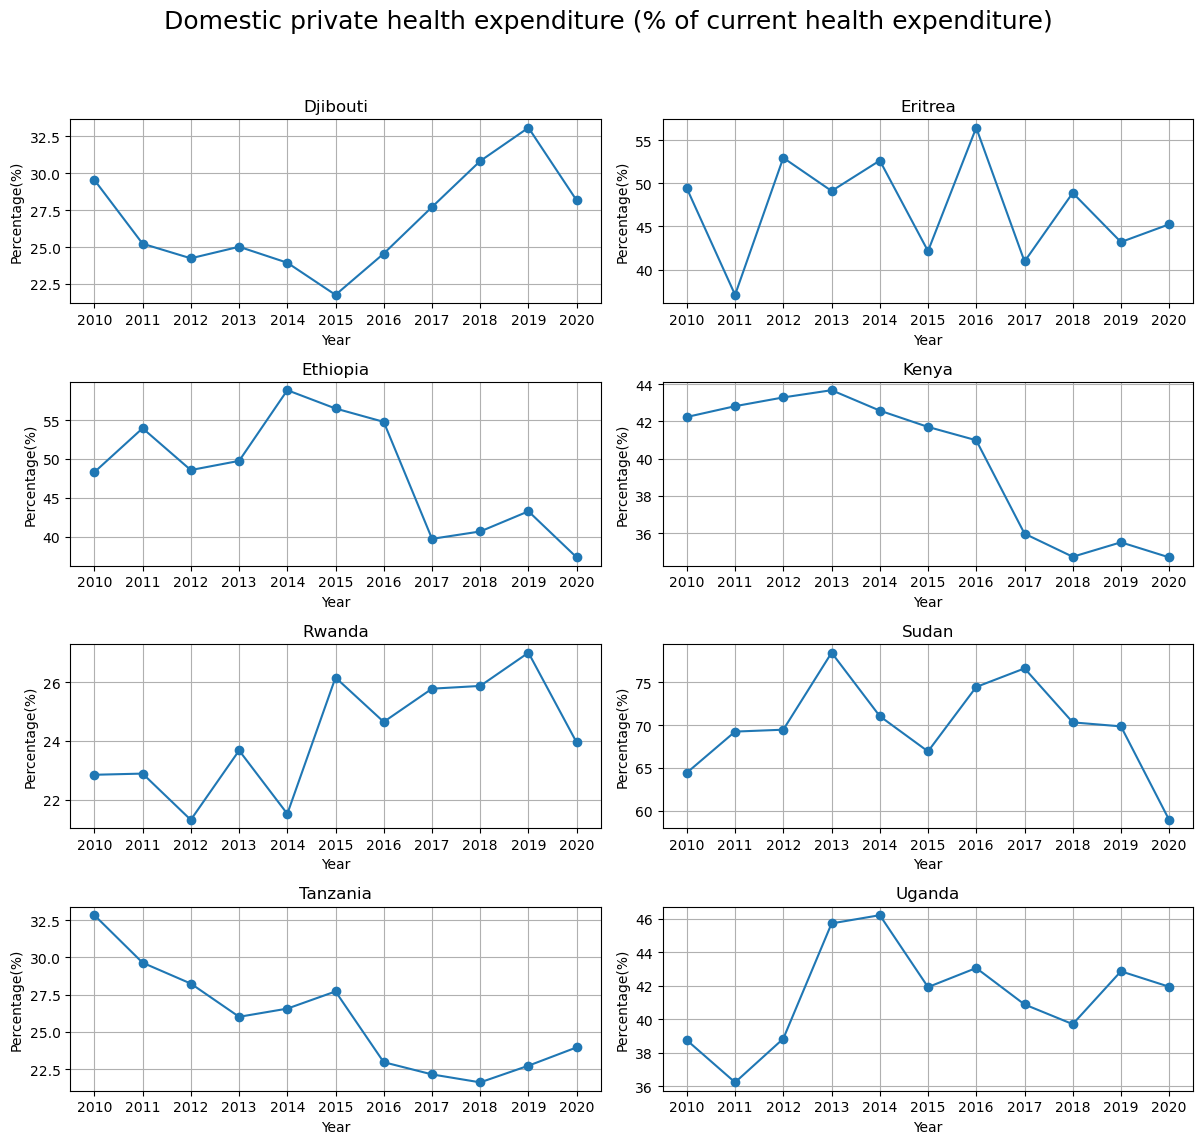

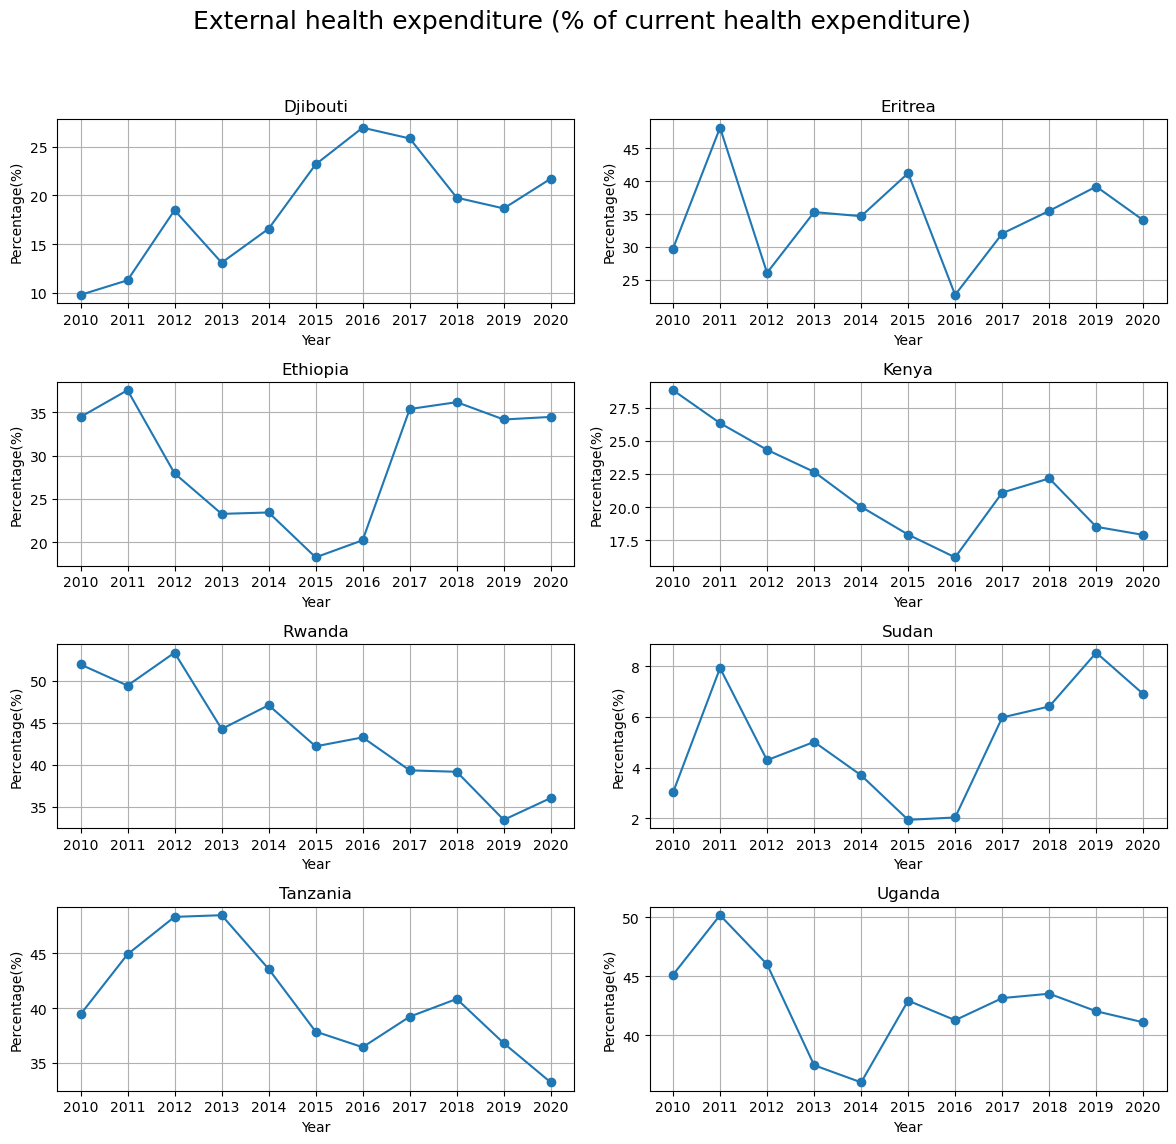

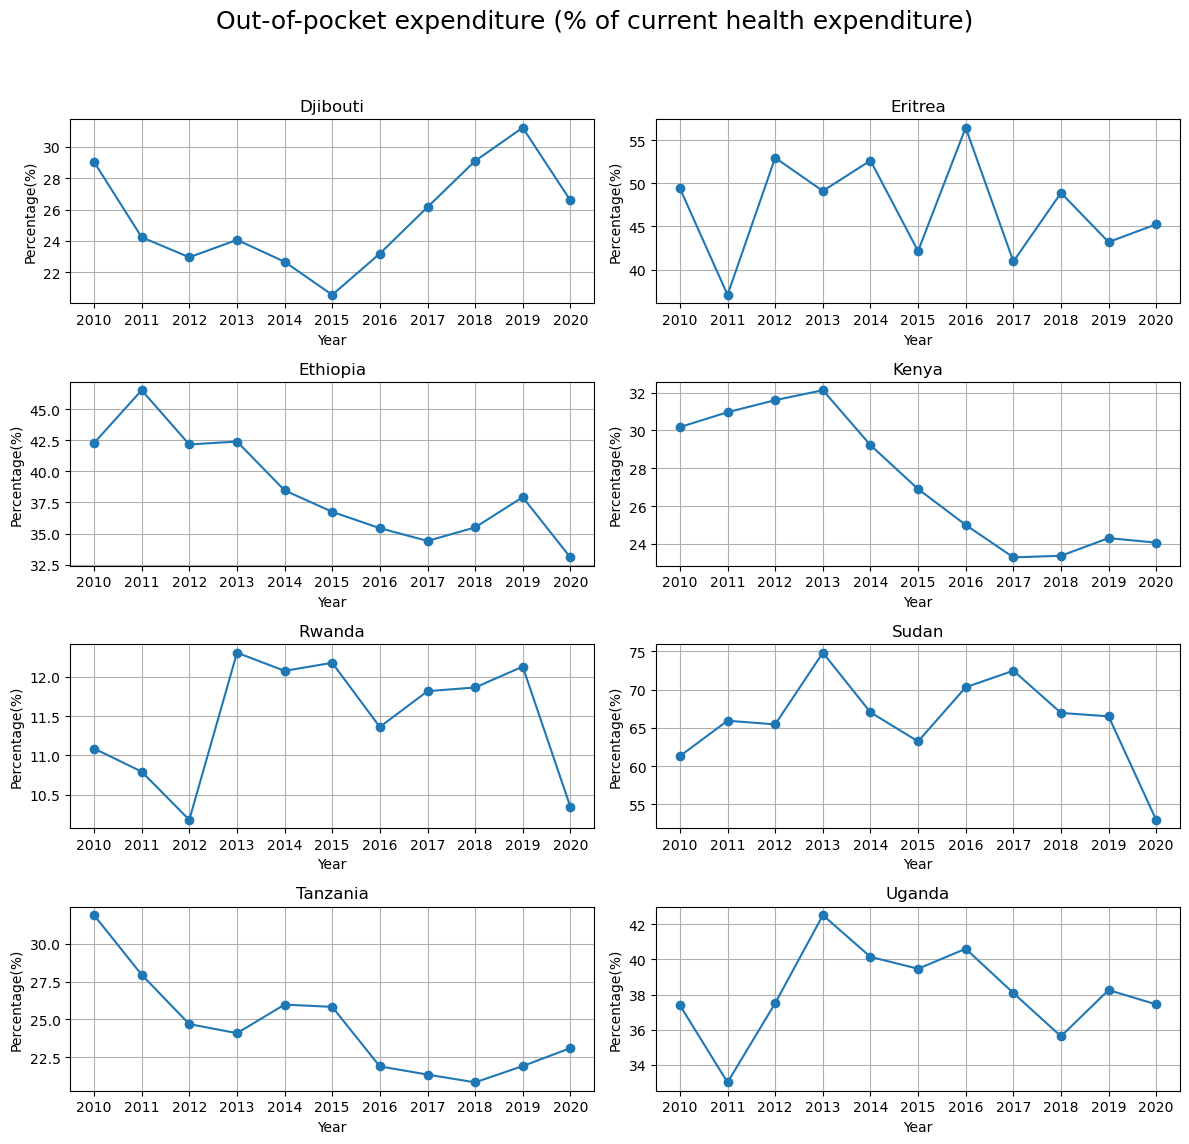

In [17]:

def plot(df, ax, indicator, country):
    ax.plot(df.index, df['Percentage'], marker='o', label=indicator)
    ax.set_title(f'{country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage(%)')
    ax.grid(True)
    # ax.legend()

# Retrieve country-specific data
country_dfs = create_country_dfs(health_df)

# List of indicators
indicators = [
'Current health expenditure (% of GDP)',
'Domestic general government health expenditure (% of current health expenditure)',
'Domestic general government health expenditure (% of GDP)',
'Domestic general government health expenditure (% of general government expenditure)',
'Domestic private health expenditure (% of current health expenditure)',
'External health expenditure (% of current health expenditure)',
'Out-of-pocket expenditure (% of current health expenditure)'
]

# Iterate over the indicators and plot the data for each country
for indicator in indicators:
    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

    # Add a main title to the figure
    fig.suptitle(f'{indicator}', fontsize=18)

    # Iterate over the subplots and plot the data for each country
    for i, (country, country_data) in enumerate(country_dfs.items()):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        if indicator in country_data:
            plot(country_data[indicator], ax, indicator, country)

    # Adjust the layout to prevent titles from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()

#### Time Series Analysis

In [18]:
health_df.head()

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,3.061504
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,60.679157
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.857695
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,6.970487
2010-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,29.537765


In [19]:
def adf_test_indicator(df, country):
    country_df = df[df['Country'] == country]
    indicator_results = {}
    
    unique_indicators = country_df['Indicator Name'].unique()
    for indicator in unique_indicators:
        indicator_data = country_df[country_df['Indicator Name'] == indicator]['Percentage']
        
        # Check if the data is constant
        if indicator_data.var() == 0:
            continue  # Skip the Dickey-Fuller test
        
        # Perform the Dickey-Fuller test
        result = adfuller(indicator_data)
        
        # Store the result in the dictionary
        indicator_results[indicator] = {
            'ADF Statistic': result[0],
            'P-value': result[1],
            'Critical Values': result[4]
        }
    
    return indicator_results


In [20]:
health_df[health_df['Country'] == 'Eritrea']

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Eritrea,Current health expenditure (% of GDP),Health: Health systems,4.929461
2010-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,20.832497
2010-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,1.026930
2010-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,2.354107
2010-01-01,Eritrea,Domestic private health expenditure (% of curr...,Health: Health systems,49.408188
...,...,...,...,...
2020-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,0.846498
2020-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,2.354107
2020-01-01,Eritrea,Domestic private health expenditure (% of curr...,Health: Health systems,45.249561


In [21]:
countries = ['Tanzania', 'Kenya', 'Uganda', 'Rwanda', 'Ethiopia','Sudan']
results = {}

for country in countries:
    country_results = adf_test_indicator(health_df, country)
    results[country] = list(country_results.items())

# Print the stationarity results for all countries
for country, country_results in results.items():
    print(f"Indicators in {country} and stationarity:")
    for indicator, result in country_results:
        print(f"{indicator}:")
        if result['ADF Statistic'] < result['Critical Values']['1%'] and result['P-value'] < 0.05:
            print("Stationary")
        else:
            print("Not Stationary")
        print()

Indicators in Tanzania and stationarity:
Current health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of current health expenditure):
Not Stationary

Domestic general government health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of general government expenditure):
Not Stationary

Domestic private health expenditure (% of current health expenditure):
Not Stationary

External health expenditure (% of current health expenditure):
Not Stationary

Out-of-pocket expenditure (% of current health expenditure):
Not Stationary

Indicators in Kenya and stationarity:
Current health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of current health expenditure):
Not Stationary

Domestic general government health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of general government expenditure):
Not Stationary

Domestic private h

### MODELLING

#### Splitting into train and test dataset

In [22]:
health_df.head()

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,3.061504
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,60.679157
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.857695
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,6.970487
2010-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,29.537765


#### Splitting the Data

In [23]:
# Splitting the data
train_ratio = 0.6  # Specify the ratio of training data
split_index = int(len(health_df) * train_ratio)  # Calculate the index to split the data

train_data = health_df[:'2018']
test_data = health_df['2018':]

In [24]:
test_data

,Country,Indicator Name,Topic,Percentage
Years,,,,
2018-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,2.262545
2018-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,49.407360
2018-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.117864
2018-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,4.311396
2018-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,30.820978
...,...,...,...,...
2020-01-01,Uganda,Domestic general government health expenditure...,Health: Health systems,0.672564
2020-01-01,Uganda,Domestic general government health expenditure...,Health: Health systems,3.138830
2020-01-01,Uganda,Domestic private health expenditure (% of curr...,Health: Health systems,41.942467


#### Differencing the data

In [25]:
# Splits input data indicators by country
def split_data(country):
    differenced_test_data = create_country_dfs(test_data)[country]
    differenced_train_data = create_country_dfs(train_data)[country]
    return differenced_test_data,differenced_train_data


#### Tanzania

In [25]:
# Training data and testing data for Tanzania
tanzania_df = split_data('Tanzania')
training_data = tanzania_df[1]
testing_data = tanzania_df[0]

In [26]:
training_data['Current health expenditure (% of GDP)']['Percentage Diff']

Years
2010-01-01    0.000000
2011-01-01   -0.167937
2012-01-01   -0.038191
2013-01-01   -0.371360
2014-01-01   -0.631513
2015-01-01   -0.365221
2016-01-01    0.313804
2017-01-01    0.119071
2018-01-01    0.079342
Name: Percentage Diff, dtype: float64
Country  ... Percentage Diff
Years                 ...                
2010-01-01  Tanzania  ...        0.000000
2011-01-01  Tanzania  ...       -0.167937
2012-01-01  Tanzania  ...       -0.038191
2013-01-01  Tanzania  ...       -0.371360
2014-01-01  Tanzania  ...       -0.631513
2015-01-01  Tanzania  ...       -0.365221
2016-01-01  Tanzania  ...        0.313804
2017-01-01  Tanzania  ...        0.119071
2018-01-01  Tanzania  ...        0.079342

                             Topic  Percentage  Percentage Diff  
Years                                                            
2010-01-01  Health: Health systems    5.223922         0.000000  
2011-01-01  Health: Health systems    5.055985        -0.167937  
2012-01-01  Health: Health systems 

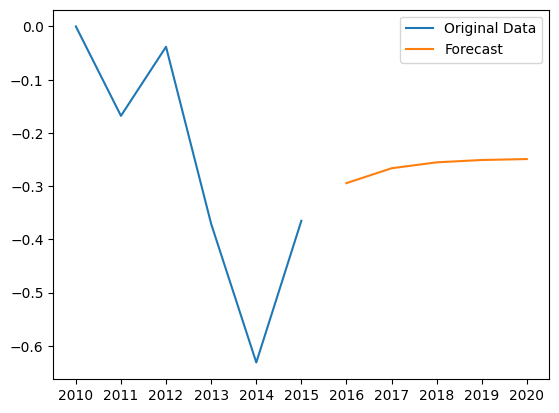

In [27]:
# Fit the ARIMA model
model = sm.tsa.ARIMA(training_data['Current health expenditure (% of GDP)']['Percentage Diff'], order=(1,0,0))
results = model.fit()

# Make predictions
forecast = results.forecast(steps=len(testing_data['Current health expenditure (% of GDP)']))

# Evaluate and visualize predictions
plt.plot(training_data['Current health expenditure (% of GDP)']['Percentage Diff'], label='Original Data')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

In [30]:
train_dict = {}
test_dict = {}

for indicator in training_data.keys():
    # Fit the ARIMA model
    model = sm.tsa.ARIMA(training_data[indicator]['Percentage Diff'], order=(1, 0, 0))
    results = model.fit()

    # Make predictions
    test_forecast = results.forecast(steps=len(testing_data[indicator]))
    train_forecast = results.forecast(steps=len(training_data[indicator]))

    # Evaluate
    train_rmse = mean_squared_error(training_data[indicator]['Percentage Diff'], train_forecast, squared=False)
    test_rmse = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

    train_dict[indicator] = train_rmse
    test_dict[indicator] = test_rmse


In [31]:
train_dict

{'Current health expenditure (% of GDP)': 0.2778051738185719,
 'Domestic general government health expenditure (% of current health expenditure)': 3.0483850945598157,
 'Domestic general government health expenditure (% of GDP)': 0.13608289932963435,
 'Domestic general government health expenditure (% of general government expenditure)': 0.8042159400065927,
 'Domestic private health expenditure (% of current health expenditure)': 1.8028983817144353,
 'External health expenditure (% of current health expenditure)': 3.4745242573797506,
 'Out-of-pocket expenditure (% of current health expenditure)': 1.9006855090206805}

In [32]:
test_dict

{'Current health expenditure (% of GDP)': 0.12702906955736756,
 'Domestic general government health expenditure (% of current health expenditure)': 1.6341284192278527,
 'Domestic general government health expenditure (% of GDP)': 0.015332967106993042,
 'Domestic general government health expenditure (% of general government expenditure)': 0.21030852765432728,
 'Domestic private health expenditure (% of current health expenditure)': 2.190572690303093,
 'External health expenditure (% of current health expenditure)': 3.54473667778611,
 'Out-of-pocket expenditure (% of current health expenditure)': 2.0329461790320282}

In [41]:
def arima_model(country, order = (1, 0, 0)):
    data = split_data(country)
    training_data = data[1]
    testing_data = data[0]

    train_rmse_dict = {}
    test_rmse_dict = {}

    for indicator in training_data.keys():
        # Fit the ARIMA model
        model = sm.tsa.ARIMA(training_data[indicator]['Percentage Diff'], order = order)
        results = model.fit()

        # Make predictions
        test_forecast = results.forecast(steps=len(testing_data[indicator]))
        train_forecast = results.forecast(steps=len(training_data[indicator]))

        # Evaluate
        train_rmse = mean_squared_error(training_data[indicator]['Percentage Diff'], train_forecast, squared=False)
        test_rmse = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

        train_rmse_dict[indicator] = train_rmse
        test_rmse_dict[indicator] = test_rmse
        
    result_str = "ARIMA Model Results:\n\n"
    result_str += "Train RMSE:\n"
    for indicator, rmse in train_rmse_dict.items():
        result_str += f"{indicator}: {rmse:.4f}\n"

    result_str += "\n"
    result_str += "Test RMSE:\n"
    for indicator, rmse in test_rmse_dict.items():
        result_str += f"{indicator}: {rmse:.4f}\n"

    return result_str

In [34]:
for country in health_df['Country'].unique():
    print(f"\n{country}")
    print("==="*10)
    print(arima_model(country))
    print("===="*25)


Djibouti
ARIMA Model Results:

Train RMSE:
Current health expenditure (% of GDP): 0.2305
Domestic general government health expenditure (% of current health expenditure): 4.1076
Domestic general government health expenditure (% of GDP): 0.1929
Domestic general government health expenditure (% of general government expenditure): 1.0344
Domestic private health expenditure (% of current health expenditure): 2.3416
External health expenditure (% of current health expenditure): 3.9679
Out-of-pocket expenditure (% of current health expenditure): 2.4074

Test RMSE:
Current health expenditure (% of GDP): 0.1283
Domestic general government health expenditure (% of current health expenditure): 3.0805
Domestic general government health expenditure (% of GDP): 0.0705
Domestic general government health expenditure (% of general government expenditure): 0.5093
Domestic private health expenditure (% of current health expenditure): 3.3619
External health expenditure (% of current health expenditure):

#### Auto-Regressive Model (AR)

##### Plotting PACF

In [ ]:
def plot_pacf_indicators(country):
    data = split_data(country)
    pacf_train_data = data[1]
    column_name = 'Percentage Diff'  # Replace with the actual column name
    
    indicators = list(pacf_train_data.keys())
    num_indicators = len(indicators)
    grid_cols = 2  # Adjust the number of columns as needed
    grid_rows = (num_indicators + grid_cols - 1) // grid_cols

    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 12))
    fig.suptitle(f'Partial Autocorrelation Function (PACF) - {country}', fontsize=16)
    axs = axs.flatten()

    for i, indicator in enumerate(indicators):
        ax = axs[i]

        if indicator in pacf_train_data:
            pacf_data = pacf_train_data[indicator][column_name]
            plot_pacf(pacf_data,lags=3, ax=ax)
            ax.set_title(indicator)
            ax.set_xlabel('Lag')
            ax.set_ylabel('PA')

    for j in range(num_indicators, len(axs)):
        axs[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

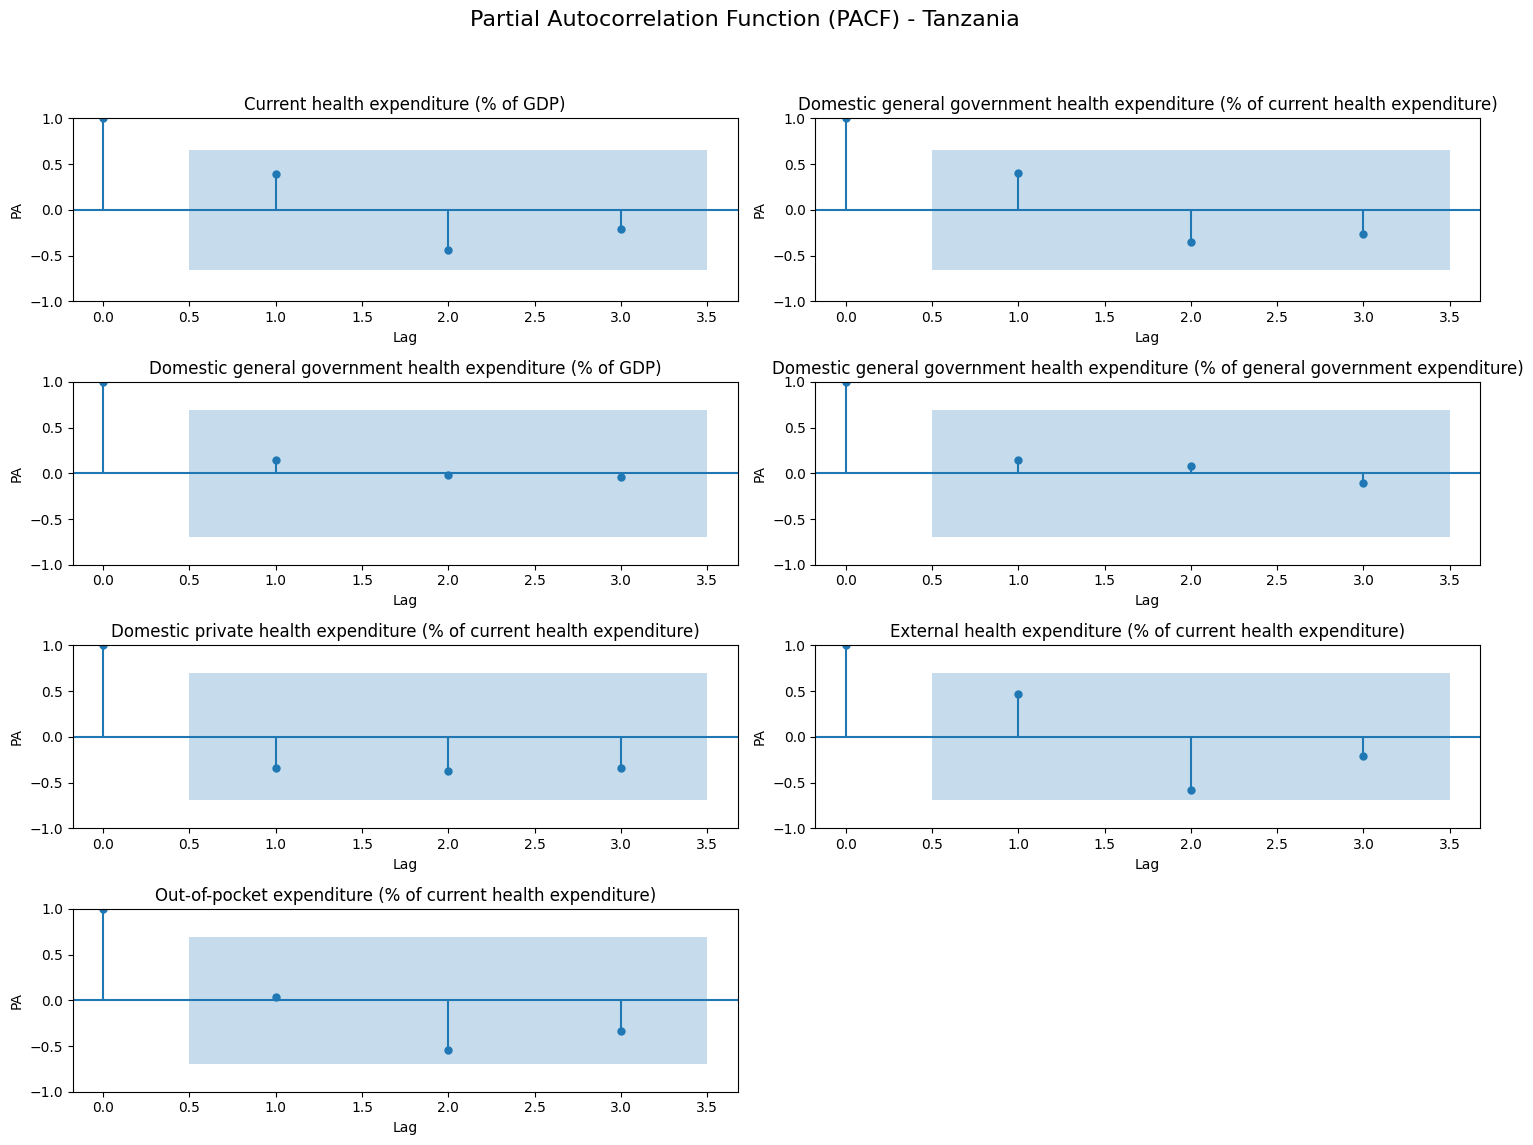

In [36]:
plot_pacf_indicators('Tanzania')

In [56]:

import pickle


def AR_model(country, order):
    data = split_data(country)
    ar_train_data = data[1]

    for indicator, ar_data in ar_train_data.items():
        # Fit the AR model
        model = sm.tsa.AutoReg(ar_data['Percentage Diff'], lags=order)
        ar_model = model.fit()

        # Get the predicted values for training data
        ar_train_predictions = ar_model.predict(start=order, end=len(ar_data)-1)
        
        # Saving the model
        with open('AR_model.pkl','wb') as f:
            pickle.dump(ar_model,f)

        # Calculate RMSE for training data
        train_rmse = np.sqrt(mean_squared_error(ar_data['Percentage Diff'][order:], ar_train_predictions,squared=False))
        print(f'\n{country}')
        print(indicator)
        print(f"Train RMSE : {train_rmse:.4f}")

        # Get the corresponding test data for the indicator
        ar_test_data = data[0][indicator]['Percentage Diff']

        # Get the predicted values for test data
        ar_test_predictions = ar_model.predict(start=len(ar_data), end=len(ar_data)+len(ar_test_data)-1)

        # Calculate RMSE for test data
        test_rmse = np.sqrt(mean_squared_error(ar_test_data, ar_test_predictions,squared=False))
        print(indicator)
        print(( f"Test RMSE : {test_rmse:.4f}"))

In [57]:
for country in health_df['Country'].unique():
    AR_model(country,order=1)


Djibouti
Current health expenditure (% of GDP)
Train RMSE : 0.4761
Current health expenditure (% of GDP)
Test RMSE : 0.3218

Djibouti
Domestic general government health expenditure (% of current health expenditure)
Train RMSE : 1.9908
Domestic general government health expenditure (% of current health expenditure)
Test RMSE : 1.6895

Djibouti
Domestic general government health expenditure (% of GDP)
Train RMSE : 0.4248
Domestic general government health expenditure (% of GDP)
Test RMSE : 0.3337

Djibouti
Domestic general government health expenditure (% of general government expenditure)
Train RMSE : 0.9921
Domestic general government health expenditure (% of general government expenditure)
Test RMSE : 0.6050

Djibouti
Domestic private health expenditure (% of current health expenditure)
Train RMSE : 1.5485
Domestic private health expenditure (% of current health expenditure)
Test RMSE : 2.0606

Djibouti
External health expenditure (% of current health expenditure)
Train RMSE : 2.1687

In [44]:
AR_model('Kenya', order=2)

Training RMSE - Current health expenditure (% of GDP) (Kenya): 0.4713
Test RMSE - Current health expenditure (% of GDP) (Kenya): 0.6047
Training RMSE - Domestic general government health expenditure (% of current health expenditure) (Kenya): 1.0545
Test RMSE - Domestic general government health expenditure (% of current health expenditure) (Kenya): 1.0501
Training RMSE - Domestic general government health expenditure (% of GDP) (Kenya): 0.3830
Test RMSE - Domestic general government health expenditure (% of GDP) (Kenya): 0.3219
Training RMSE - Domestic general government health expenditure (% of general government expenditure) (Kenya): 0.7033
Test RMSE - Domestic general government health expenditure (% of general government expenditure) (Kenya): 0.7685
Training RMSE - Domestic private health expenditure (% of current health expenditure) (Kenya): 1.2040
Test RMSE - Domestic private health expenditure (% of current health expenditure) (Kenya): 2.4146
Training RMSE - External health expe

In [42]:
AR_model('Kenya', order=1)

Training RMSE - Current health expenditure (% of GDP) (Kenya): 0.4586
Test RMSE - Current health expenditure (% of GDP) (Kenya): 0.4782
Training RMSE - Domestic general government health expenditure (% of current health expenditure) (Kenya): 1.0623
Test RMSE - Domestic general government health expenditure (% of current health expenditure) (Kenya): 0.9625
Training RMSE - Domestic general government health expenditure (% of GDP) (Kenya): 0.3720
Test RMSE - Domestic general government health expenditure (% of GDP) (Kenya): 0.1195
Training RMSE - Domestic general government health expenditure (% of general government expenditure) (Kenya): 0.7823
Test RMSE - Domestic general government health expenditure (% of general government expenditure) (Kenya): 0.3045
Training RMSE - Domestic private health expenditure (% of current health expenditure) (Kenya): 1.2802
Test RMSE - Domestic private health expenditure (% of current health expenditure) (Kenya): 0.8667
Training RMSE - External health expe

In [55]:
with open('AR_model.pkl','rb') as f:
    loaded_model = pickle.load(f)



## SES

## HWES

In [ ]:
# For one country
def holt_winters_model(country, seasonal=None, trend='multiplicative', seasonal_periods=12):
    testing_data, training_data = split_data(country)  

    train_rmse = {}
    test_rmse = {}

    for indicator in training_data:
        # Fit the Holt-Winters model
        model = sm.tsa.ExponentialSmoothing(
            training_data[indicator]['Percentage Diff'],
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            trend=trend
        )
        model_fit = model.fit()

        # Make predictions on training and testing data
        train_forecast = model_fit.fittedvalues
        test_forecast = model_fit.forecast(steps=len(testing_data[indicator]))

        # Evaluate the forecasts
        train_rmse[indicator] = mean_squared_error(training_data[indicator]['Percentage Diff'], train_forecast, squared=False)
        test_rmse[indicator] = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

        # Optional: Plot the observed vs. predicted values for testing data
        plt.figure(figsize=(12, 6))
        plt.plot(training_data[indicator].index, training_data[indicator]['Percentage Diff'], label='Training Data')
        plt.plot(testing_data[indicator].index, testing_data[indicator]['Percentage Diff'], label='Testing Data')
        plt.plot(testing_data[indicator].index, test_forecast, label='Holt-Winters Forecast')
        plt.title(f'Holt-Winters Forecast for {indicator} in {country}')
        plt.legend()
        plt.show()

    return "Train RMSE:", train_rmse, "Test RMSE:", test_rmse


In [ ]:
holt_winters_model('Tanzania', seasonal=None, trend='add', seasonal_periods=12)

Fine tuning

In [ ]:
def find_best_holt_winters_parameters_for_indicators(country, seasonal_periods_range, trend_options):
    testing_data, training_data = split_data(country)
    
    best_params = {}
    best_rmse = {}

    for indicator in training_data:
        best_rmse[indicator] = float('inf')
        best_params[indicator] = None

    for indicator in training_data:
        for seasonal_periods in seasonal_periods_range:
            for trend in trend_options:
                # Fit the Holt-Winters model
                model = sm.tsa.ExponentialSmoothing(
                    training_data[indicator]['Percentage Diff'],
                    seasonal='add',
                    seasonal_periods=seasonal_periods,
                    trend=trend
                )
                model_fit = model.fit()

                # Make predictions on training and testing data
                train_forecast = model_fit.fittedvalues
                test_forecast = model_fit.forecast(steps=len(testing_data[indicator]))

                # Calculate RMSE for testing data
                test_rmse = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

                # Update best parameters and RMSE for this indicator
                if test_rmse < best_rmse[indicator]:
                    best_rmse[indicator] = test_rmse
                    best_params[indicator] = (seasonal_periods, trend)

    return "Best Parameters:", best_params, "Best RMSE:", best_rmse


In [ ]:
holt_winters_model('Tanzania', seasonal=None, seasonal_periods=2, trend=None)

In [ ]:
# For all the countries
def holt_winters_model_east_africa(east_african_countries, seasonal='multiplicative', trend='multiplicative', seasonal_periods=2):
    
    for country in east_african_countries:

        # Split the data for the specific country
        data = split_data(country)
        training_data = data[1]
        testing_data = data[0]

        # Create subplots for each indicator
        num_indicators = len(training_data)
        num_rows = num_indicators // 2 + num_indicators % 2
        num_cols = 2

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))
        fig.suptitle(f'{country} - Holt-Winters Forecasting')

        for i, indicator in enumerate(training_data):
            row = i // 2
            col = i % 2
            
            
            # Fit the Holt-Winters model
            model = sm.tsa.ExponentialSmoothing(
                training_data[indicator]['Percentage Diff'],
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                trend=trend,
            )
            model_fit = model.fit()

            # Make predictions on training and testing data
            train_forecast = model_fit.fittedvalues
            test_forecast = model_fit.forecast(steps=len(testing_data[indicator]))

            # Plot training data, testing data, and forecasts
            axes[row, col].plot(training_data[indicator].index, training_data[indicator]['Percentage Diff'], label='Training Data', color='blue')
            axes[row, col].plot(testing_data[indicator].index, testing_data[indicator]['Percentage Diff'], label='Testing Data', color='green')
            axes[row, col].plot(testing_data[indicator].index, test_forecast, label='Forecast', color='red')
            axes[row, col].set_title(f'{indicator} - RMSE: {mean_squared_error(testing_data[indicator]["Percentage Diff"], test_forecast, squared=False):.2f}')
        
        # For setting labels and grids in each plot
        for ax in axes.flat:
            ax.set(xlabel='Year', ylabel='Percentage Diff')
            ax.legend()
            ax.grid()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [ ]:
holt_winters_model_east_africa(eastern_countries, seasonal=None, trend='add', seasonal_periods=2)

Fine tuning

In [ ]:

def find_best_holt_winters_parameters(east_african_countries, seasonal_periods, trend_options):
    best_params = {}
    best_rmse = {}

    for country in east_african_countries:
        testing_data, training_data = split_data(country)
        best_params[country] = {}
        best_rmse[country] = {}

        for indicator in training_data:
            best_rmse[country][indicator] = float('inf')
            best_params[country][indicator] = None

        for indicator in training_data:
            for seasonal in seasonal_periods:
                for trend in trend_options:
                    # Fit the Holt-Winters model
                    model = sm.tsa.ExponentialSmoothing(
                        training_data[indicator]['Percentage Diff'],
                        seasonal='add',
                        seasonal_periods=seasonal,
                        trend=trend
                    )
                    model_fit = model.fit()

                    # Make predictions on training and testing data
                    train_forecast = model_fit.fittedvalues
                    test_forecast = model_fit.forecast(steps=len(testing_data[indicator]))

                    # Calculate RMSE for testing data
                    test_rmse = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

                    # Update best parameters and RMSE for this indicator
                    if test_rmse < best_rmse[country][indicator]:
                        best_rmse[country][indicator] = test_rmse
                        best_params[country][indicator] = (seasonal, trend)

    return best_params, best_rmse


In [ ]:
holt_winters_model_east_africa(eastern_countries, seasonal=None, trend=None, seasonal_periods=2)

## LSTM

In [ ]:
def lstm_model(country):
    data = split_data(country)
    training_data = data[1]
    testing_data = data[0]

    # emtpy dictionary
    train_rmse = {}
    test_rmse = {}
    
    for indicator in  training_data.keys():
        train_values = training_data[indicator]['Percentage Diff'].values.reshape(-1, 1)
        test_values = testing_data[indicator]['Percentage Diff'].values.reshape(-1, 1)

        n_steps = 3

        # Split the data into samples
        X_train, y_train = [], []
        for i in range(n_steps, len(train_values)):
            X_train.append(train_values[i-n_steps:i, 0])
            y_train.append(train_values[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)

        X_test, y_test = [], []
        for i in range(n_steps, len(test_values)):
            X_test.append(test_values[i-n_steps:i, 0])
            y_test.append(test_values[i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)

        # Reshape the data for input into the LSTM model
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Remove invalid characters from the indicator name
        indicator = re.sub(r'[^A-Za-z0-9_./-]', '', indicator)

        # Intializing the Sequential model
        model = Sequential(name=f"{indicator}_lstm_model")

        # Input Layer
        model.add(LSTM(124, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
        # Hidden Layer
        model.add(LSTM(124, activation='relu', return_sequences=True))
        model.add(LSTM(64, activation='relu', return_sequences=False))
        # model.add(GRU(32, activation='relu'))
        # Output layer
        model.add(Dense(1))

        # Compile
        model.compile(
            optimizer = Adam(learning_rate=0.001),
            loss = 'mean_squared_error'
        )
        # Creating a EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

        # Defining the path for saving checkpoints
        checkpoint_folder = "weights"
        os.makedirs(checkpoint_folder, exist_ok=True)
        checkpoint_filepath = os.path.join(checkpoint_folder, f'{country}_{indicator}_lstm_model.h5')

        # Create a ModelCheckpoint callback to save the best model weights
        model_checkpoint = ModelCheckpoint(
            checkpoint_filepath,
            monitor='val_loss',  
            save_best_only=True, 
            mode='min',  
            verbose=0  
        )
        # Fitting the model
        model.fit(
            X_train, 
            y_train,
            epochs=100,
            callbacks=[early_stopping, model_checkpoint],
            validation_data=(X_test, y_test),
            verbose=0
        )
        # Loading the model weights
        model.load_weights(os.path.join(checkpoint_folder, f'{country}_{indicator}_lstm_model.h5'))
        # Predicting X_train
        y_pred_train = model.predict(X_train)
        rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
        train_rmse[indicator] = rmse_train
        # Predicting X_test
        y_pred_test = model.predict(X_test)
        rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
        test_rmse[indicator] = rmse_test
        
    result_str = "LSTM Model Results:\n\n"
    
    result_str += "Train RMSE:\n"
    for indicator, rmse in train_rmse.items():
        result_str += f"{indicator}: {rmse:.4f}\n"

    result_str += "\nTest RMSE:\n"
    for indicator, rmse in test_rmse.items():
        result_str += f"{indicator}: {rmse:.4f}\n"

    return result_str
        

In [ ]:
for country in health_df['Country'].unique():
    print(f"\n{country}")
    print("==="*10)
    print(lstm_model(country))
    print("===="*25)